# 0. Import libraries

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import requests
import io
import folium
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# 1. Toronto neighbourhoods

In [2]:
# get data from wikipedia
get_data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(get_data,'xml')

# Build initial table
postal_codes_table = soup.table
elements = postal_codes_table('td')

Postcode, Borough, Neighbourhood = [], [], []

# put the information into lists
for n in range (0,len(elements), 3):
    Postcode.append(elements[n])
    Borough.append(elements[n+1])
    Neighbourhood.append(elements[n+2])

# remove html tags
for n in range (len(Postcode)):
    Postcode[n] = Postcode[n].text.strip()
    Borough[n] = Borough[n].text.strip()
    Neighbourhood[n] = Neighbourhood[n].text.strip()

# creating dataframe
initial_dataframe = pd.DataFrame([Postcode, Borough, Neighbourhood])
initial_dataframe = initial_dataframe.transpose()
initial_dataframe.columns = ['Postcode', 'Borough', 'Neighbourhood']

# remove rows with 'Not assigned'
dataframe = initial_dataframe[initial_dataframe.Borough != 'Not assigned']

# Combine more than one neighborhood in one postal code area
#dataframe = dataframe.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

# Not assigned neighborhood have to be the same as the borough
for index, row in dataframe.iterrows():
    if row['Neighbourhood'] == 'Not assigned': row['Neighbourhood'] = row['Borough']

# get coordinates
coord = requests.get("http://cocl.us/Geospatial_data").content.decode('utf-8')
dataframe_coord = pd.read_csv(io.StringIO(coord))
dataframe_coord.head()

# rename column to be equal in both dataframes
dataframe.rename(columns = {'Postcode': 'Postal Code'}, inplace=True)
# merge two dataframes
df_coord = pd.merge(dataframe, dataframe_coord, on = 'Postal Code')
df_coord.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


### Statistics of Toronto boroughs and neighbourhoods

In [3]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_coord['Borough'].unique()), df_coord.shape[0]))

The dataframe has 11 boroughs and 211 neighborhoods.


In [4]:
# Number of neighbourhoods per borough
df_coord.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto     17
Downtown Toronto    37
East Toronto         7
East York            6
Etobicoke           45
Mississauga          1
North York          38
Queen's Park         1
Scarborough         37
West Toronto        13
York                 9
Name: Neighbourhood, dtype: int64

### Define different colours for boroughs

In [5]:
# list of boroughs
boroughs_list = df_coord['Borough'].unique().tolist()

# define colours
boroughs_dict = {}
colour_list = ["red", "blue", "green", "yellow","orange", "black", "gray", "pink", "darkgreen", "lightred", "purple"]
for i, boroughs in enumerate(boroughs_list):
    boroughs_dict[boroughs_list[i]] = colour_list[i]
boroughs_dict

{'North York': 'red',
 'Downtown Toronto': 'blue',
 "Queen's Park": 'green',
 'Etobicoke': 'yellow',
 'Scarborough': 'orange',
 'East York': 'black',
 'York': 'gray',
 'East Toronto': 'pink',
 'West Toronto': 'darkgreen',
 'Central Toronto': 'lightred',
 'Mississauga': 'purple'}

### Extract the Toronto coordinates

In [6]:
latitude_toronto = df_coord['Latitude'].mean()
longitude_toronto = df_coord['Longitude'].mean()
print('The coordinates of Toronto are {:2f} (lat.) and {:2f} (long.)'.format(latitude_toronto, longitude_toronto))

The coordinates of Toronto are 43.697394 (lat.) and -79.409633 (long.)


### Build map of Toronto

In [7]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# draw markers
for latitude, longitude, borough, neighbourhood in zip(df_coord['Latitude'], df_coord['Longitude'], df_coord['Borough'], df_coord['Neighbourhood']):
    label_text = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color=boroughs_dict[borough],
        fill=True,
        fill_color=boroughs_dict[borough],
        fill_opacity=0.6).add_to(map_toronto)
    
map_toronto

# 2. Analyse demographics: Neighbourhoods with strong  Mediterranean influences

### Get information from Wikipedia

In [8]:
# get data from wikipedia
get_data = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(get_data.content,'lxml')
demographics_table = soup.find_all('table')
df_demographics = pd.read_html(str(demographics_table[1]), index_col=None, header=0)[0]
df_demographics.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


### Prepare / clean data for further analysis

In [9]:
# eleminate some columns
df_demograph = df_demographics
for i in 1,1,2,2,2,3,3,3,4:
    df_demograph = df_demograph.drop(df_demograph.columns[i], axis = 1)

# rename some columns
df_demograph.rename(columns ={"Name": "Neighbourhood"}, inplace = True)
df_demograph.rename(columns ={"Second most common language (after English) by percentage": "Foreign Language"}, inplace = True)
df_demograph["Foreign Language"] = df_demograph["Foreign Language"].str.replace("Unspecified Chinese", "Chinese")

# define the index
df_demograph.set_index(['Neighbourhood'], inplace=True)

df_demograph.head()

,Population,Average Income,Foreign Language
Neighbourhood,,,
Toronto CMA Average,5113149,40704,NaN
Agincourt,44577,25750,19.3% Cantonese
Alderwood,11656,35239,06.2% Polish
Alexandra Park,4355,19687,17.9% Cantonese
Allenby,2513,245592,01.4% Russian


In [10]:
# Split the column "Foreign Language"
split_columns = df_demograph["Foreign Language"].str.split(" ", n = 1, expand = True)
df_demograph["Percentage"]= split_columns[0]
df_demograph["Language"]= split_columns[1]
df_demograph = df_demograph.drop(df_demograph.columns[2], axis = 1)
df_demograph.head()

,Population,Average Income,Percentage,Language
Neighbourhood,,,,
Toronto CMA Average,5113149,40704,NaN,NaN
Agincourt,44577,25750,19.3%,Cantonese
Alderwood,11656,35239,06.2%,Polish
Alexandra Park,4355,19687,17.9%,Cantonese
Allenby,2513,245592,01.4%,Russian


In [11]:
# Merge the dataframe with the coordinates (df.coord) with the demographics dataframe (df_language)
# Select on the target languages
df_merged = pd.merge(df_coord, df_demograph, on='Neighbourhood')
df_language = pd.DataFrame(df_merged[df_merged['Language'].isin(['Italian', 'Spanish', 'Portuguese', 'Greek'])])
df_language.reset_index(drop=True)
df_language = df_language.set_index(['Neighbourhood'])

# Change value types
df_language['Percentage'] = df_language['Percentage'].str.rstrip("%")
df_language['Percentage'] = df_language['Percentage'].astype(float)
df_language['Average Income'] = df_language['Average Income'].astype(int)
df_language

,Postal Code,Borough,Latitude,Longitude,Population,Average Income,Percentage,Language
Neighbourhood,,,,,,,,
Lawrence Heights,M6A,North York,43.718518,-79.464763,3769,29867,15.0,Italian
Eringate,M9C,Etobicoke,43.643515,-79.577201,8008,34789,3.4,Portuguese
Little Portugal,M6J,West Toronto,43.647927,-79.419750,5013,29224,23.8,Portuguese
Brockton,M6K,West Toronto,43.636847,-79.428191,9039,27260,19.9,Portuguese
Downsview,M6L,North York,43.713756,-79.490074,36613,26751,11.7,Italian
Humber Summit,M9L,North York,43.756303,-79.565963,12766,26117,15.1,Italian
Bedford Park,M5M,North York,43.733283,-79.419750,13749,80827,0.7,Greek
Mount Dennis,M6M,York,43.691116,-79.476013,21284,23910,7.3,Spanish
Silverthorn,M6M,York,43.691116,-79.476013,17757,26291,11.8,Portuguese


In [12]:
df_language_new_index = df_language
df_language_new_index.reset_index(inplace = True)
df_language_new_index.head()

,Neighbourhood,Postal Code,Borough,Latitude,Longitude,Population,Average Income,Percentage,Language
0,Lawrence Heights,M6A,North York,43.718518,-79.464763,3769,29867,15.0,Italian
1,Eringate,M9C,Etobicoke,43.643515,-79.577201,8008,34789,3.4,Portuguese
2,Little Portugal,M6J,West Toronto,43.647927,-79.419750,5013,29224,23.8,Portuguese
3,Brockton,M6K,West Toronto,43.636847,-79.428191,9039,27260,19.9,Portuguese
4,Downsview,M6L,North York,43.713756,-79.490074,36613,26751,11.7,Italian


In [13]:
# list of languages
language_list = df_language_new_index['Language'].unique().tolist()

# define colours for different languages
language_dict = {}
colour_list = ["red", "blue", "green","orange"]
for i, language in enumerate(language_list):
    language_dict[language] = colour_list[i]
language_dict

{'Italian': 'red', 'Portuguese': 'blue', 'Greek': 'green', 'Spanish': 'orange'}

### Examine the size of the Neighbourhoods

In [14]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)
# Radius of Neighbourhoods
radius_of_neigh = 1250


# draw size of Neighbourhoods
for latitude, longitude, borough, neighbourhood, language in zip(df_language_new_index['Latitude'], df_language_new_index['Longitude'], df_language_new_index['Borough'], df_language_new_index['Neighbourhood'], df_language_new_index['Language']):
    label_text = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label_text, parse_html=True)
    folium.Circle(
        [latitude, longitude],
        radius_of_neigh=1250,
        popup=label,
        color=language_dict[language],
        radius= radius_of_neigh,
        fill=True,
        fill_color=language_dict[language],
        fill_opacity=0.7).add_to(map_toronto)
    
map_toronto

#####  Result: a radius of 1250m seams to be fine

# 3. Average income and number of inhabitants with Mediterranean roots

### Rank Neighbourhouds according number of inhabitants with Mediterranean roots

In [15]:
# Calculate total income
df_inhabitants = df_language[['Neighbourhood','Population','Average Income','Percentage']]
df_inhabitants['Inhabitants with Mediterranean roots'] = df_inhabitants.apply(lambda n: int(n['Population'] * n['Percentage'] / 100), axis=1)
df_inhabitants['Inhabitants Ranking'] = df_inhabitants['Inhabitants with Mediterranean roots'].rank(ascending = False)
df_inhabitants

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Neighbourhood,Population,Average Income,Percentage,Inhabitants with Mediterranean roots,Inhabitants Ranking
0,Lawrence Heights,3769,29867,15.0,565,8.0
1,Eringate,8008,34789,3.4,272,10.0
2,Little Portugal,5013,29224,23.8,1193,6.0
3,Brockton,9039,27260,19.9,1798,4.0
4,Downsview,36613,26751,11.7,4283,1.0
5,Humber Summit,12766,26117,15.1,1927,3.0
6,Bedford Park,13749,80827,0.7,96,13.0
7,Mount Dennis,21284,23910,7.3,1553,5.0
8,Silverthorn,17757,26291,11.8,2095,2.0
9,Humberlea,4327,30907,11.1,480,9.0


In [16]:
df_inhabitants.sort_values(by='Inhabitants Ranking')

,Neighbourhood,Population,Average Income,Percentage,Inhabitants with Mediterranean roots,Inhabitants Ranking
4,Downsview,36613,26751,11.7,4283,1.0
8,Silverthorn,17757,26291,11.8,2095,2.0
5,Humber Summit,12766,26117,15.1,1927,3.0
3,Brockton,9039,27260,19.9,1798,4.0
7,Mount Dennis,21284,23910,7.3,1553,5.0
2,Little Portugal,5013,29224,23.8,1193,6.0
10,Weston,16476,27446,7.0,1153,7.0
0,Lawrence Heights,3769,29867,15.0,565,8.0
9,Humberlea,4327,30907,11.1,480,9.0
1,Eringate,8008,34789,3.4,272,10.0


### Rank Neighbourhouds according to average income

In [17]:
df_average_income = df_language[['Neighbourhood','Population','Average Income','Percentage']]
df_average_income['Average Income Rank'] = df_average_income['Average Income'].rank(ascending = False)
df_average_income

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighbourhood,Population,Average Income,Percentage,Average Income Rank
0,Lawrence Heights,3769,29867,15.0,6.0
1,Eringate,8008,34789,3.4,4.0
2,Little Portugal,5013,29224,23.8,7.0
3,Brockton,9039,27260,19.9,9.0
4,Downsview,36613,26751,11.7,10.0
5,Humber Summit,12766,26117,15.1,12.0
6,Bedford Park,13749,80827,0.7,1.0
7,Mount Dennis,21284,23910,7.3,13.0
8,Silverthorn,17757,26291,11.8,11.0
9,Humberlea,4327,30907,11.1,5.0


In [18]:
df_average_income.sort_values(by='Average Income Rank')

,Neighbourhood,Population,Average Income,Percentage,Average Income Rank
6,Bedford Park,13749,80827,0.7,1.0
11,The Annex,15602,63636,1.3,2.0
12,Church and Wellesley,13397,37653,1.8,3.0
1,Eringate,8008,34789,3.4,4.0
9,Humberlea,4327,30907,11.1,5.0
0,Lawrence Heights,3769,29867,15.0,6.0
2,Little Portugal,5013,29224,23.8,7.0
10,Weston,16476,27446,7.0,8.0
3,Brockton,9039,27260,19.9,9.0
4,Downsview,36613,26751,11.7,10.0


### Analysis of correlation between the average income and the number of inhabitants with Mediterranean roots

In [19]:
# merge dataframes
df_merged_avg_inh = pd.merge(df_average_income, df_inhabitants)
df_merged_avg_inh

,Neighbourhood,Population,Average Income,Percentage,Average Income Rank,Inhabitants with Mediterranean roots,Inhabitants Ranking
0,Lawrence Heights,3769,29867,15.0,6.0,565,8.0
1,Eringate,8008,34789,3.4,4.0,272,10.0
2,Little Portugal,5013,29224,23.8,7.0,1193,6.0
3,Brockton,9039,27260,19.9,9.0,1798,4.0
4,Downsview,36613,26751,11.7,10.0,4283,1.0
5,Humber Summit,12766,26117,15.1,12.0,1927,3.0
6,Bedford Park,13749,80827,0.7,1.0,96,13.0
7,Mount Dennis,21284,23910,7.3,13.0,1553,5.0
8,Silverthorn,17757,26291,11.8,11.0,2095,2.0
9,Humberlea,4327,30907,11.1,5.0,480,9.0


Text(0.5, 1.0, 'Average Income - Population with Mediterranean roots')

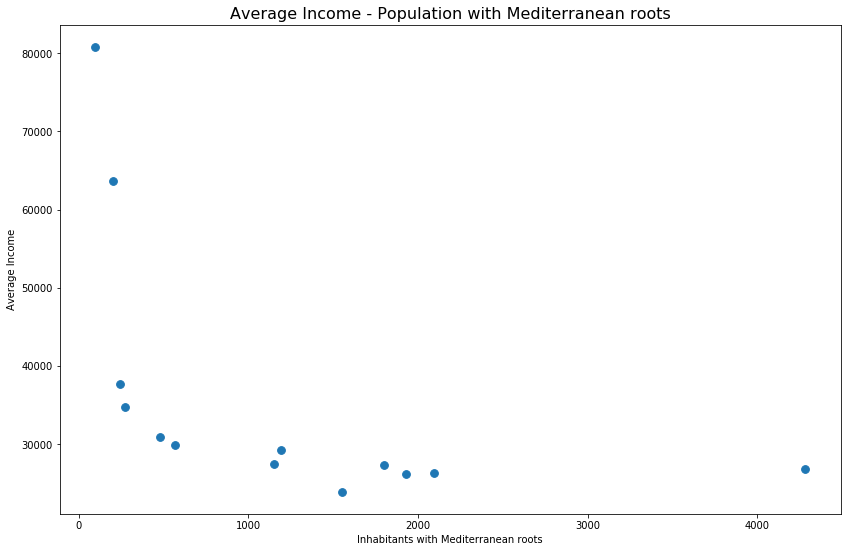

In [20]:
df_merged_avg_inh.plot.scatter(x='Inhabitants with Mediterranean roots', y='Average Income', figsize=(14,9), s= 60)
plt.title('Average Income - Population with Mediterranean roots', fontsize=16)

# 4. Foursquare analysis to identify the number of Mediterranean restaurants

In [21]:
CLIENT_ID = 'ABCDVBMVZAK1NFPWU3CEYW220NI04IQTHZ2I4LJEDDUZWKW1' # Foursquare ID
CLIENT_SECRET = 'ABCDEX5300JV1ULNFOPONVT1CKSGI0DWBJYGHC2A1INQNWBS' # Foursquare Secret
VERSION = '20180604' # Foursquare API version
limit = 100

In [22]:
def identify_venues(neighbourhoods, latitudes, longitudes):
    
    nearby_venues=[]
    for neighbourhood, latitude, longitude in zip(neighbourhoods, latitudes, longitudes):
            
        # define Foursquare URL 
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius_of_neigh, limit)

        # Send the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # assign relevant part of JSON to venues
        nearby_venues.append([(neighbourhood, latitude, longitude, r['venue']['location']['lat'], r['venue']['location']['lng'],  
            r['venue']['categories'][0]['name']) for r in results])

    # tranform venues into a dataframe
    identified_venues = pd.DataFrame([item for nearby_venues in nearby_venues for item in nearby_venues])
    identified_venues.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(identified_venues)

In [23]:
df_target = df_language
df_target.reset_index(inplace = True)
df_target

,index,Neighbourhood,Postal Code,Borough,Latitude,Longitude,Population,Average Income,Percentage,Language
0,0,Lawrence Heights,M6A,North York,43.718518,-79.464763,3769,29867,15.0,Italian
1,1,Eringate,M9C,Etobicoke,43.643515,-79.577201,8008,34789,3.4,Portuguese
2,2,Little Portugal,M6J,West Toronto,43.647927,-79.419750,5013,29224,23.8,Portuguese
3,3,Brockton,M6K,West Toronto,43.636847,-79.428191,9039,27260,19.9,Portuguese
4,4,Downsview,M6L,North York,43.713756,-79.490074,36613,26751,11.7,Italian
5,5,Humber Summit,M9L,North York,43.756303,-79.565963,12766,26117,15.1,Italian
6,6,Bedford Park,M5M,North York,43.733283,-79.419750,13749,80827,0.7,Greek
7,7,Mount Dennis,M6M,York,43.691116,-79.476013,21284,23910,7.3,Spanish
8,8,Silverthorn,M6M,York,43.691116,-79.476013,17757,26291,11.8,Portuguese
9,9,Humberlea,M9M,North York,43.724766,-79.532242,4327,30907,11.1,Italian


### Get data

In [24]:
# Get the venues category for each neighbourhood
toronto_venues = identify_venues(neighbourhoods=df_target['Neighbourhood'], latitudes=df_target['Latitude'], longitudes=df_target['Longitude'])

In [25]:
pd.options.display.max_rows = 999
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Heights,43.718518,-79.464763,43.718221,-79.466776,Boutique
1,Lawrence Heights,43.718518,-79.464763,43.721259,-79.468472,Vietnamese Restaurant
2,Lawrence Heights,43.718518,-79.464763,43.721445,-79.456504,Deli / Bodega
3,Lawrence Heights,43.718518,-79.464763,43.720610,-79.456119,Sushi Restaurant
4,Lawrence Heights,43.718518,-79.464763,43.720730,-79.456412,Burger Joint


### Filter data

In [26]:
df_restaurants = pd.DataFrame(toronto_venues[toronto_venues['Venue Category'].isin(['Mediterranean Restaurant','Greek Restaurant', 'Pizza Place', 'Argentinian Restaurant', 'Portuguese Restaurant', 'Italian Restaurant'])])
df_restaurants = df_restaurants.sort_values(by=['Venue Latitude'])
df_restaurants.drop_duplicates(subset = ['Venue Latitude'])
df_restaurants.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Latitude,Venue Longitude,Venue Category
221,Brockton,43.636847,-79.428191,43.639021,-79.425289,Italian Restaurant
96,Eringate,43.643515,-79.577201,43.641845,-79.576556,Pizza Place
190,Little Portugal,43.647927,-79.419750,43.645550,-79.411294,Italian Restaurant
123,Little Portugal,43.647927,-79.419750,43.646042,-79.419679,Greek Restaurant
300,Brockton,43.636847,-79.428191,43.646042,-79.419679,Greek Restaurant


### Count occurences

In [27]:
df_restaurants_num = pd.DataFrame(df_restaurants['Neighbourhood'].value_counts())
df_restaurants_num.rename(columns ={"Neighbourhood": "Number of Mediterranean restaurants"}, inplace = True)
df_restaurants_num.index.names = ['Neighbourhood']
df_restaurants_num

,Number of Mediterranean restaurants
Neighbourhood,
The Annex,10
Bedford Park,9
Little Portugal,9
Church and Wellesley,8
Eringate,2
Mount Dennis,2
Weston,2
Silverthorn,2
Humber Summit,2


In [28]:
df_restaurants_num_new_index = df_restaurants_num
df_restaurants_num_new_index.reset_index(inplace = True)
df_restaurants_num_new_index.head()

,Neighbourhood,Number of Mediterranean restaurants
0,The Annex,10
1,Bedford Park,9
2,Little Portugal,9
3,Church and Wellesley,8
4,Eringate,2


# 5. Clustering using k-means

### Prepare data

In [29]:
df_merged_lan_um = pd.merge(df_inhabitants, df_restaurants_num_new_index, on = 'Neighbourhood') 
df_merged_lan_um

,Neighbourhood,Population,Average Income,Percentage,Inhabitants with Mediterranean roots,Inhabitants Ranking,Number of Mediterranean restaurants
0,Lawrence Heights,3769,29867,15.0,565,8.0,1
1,Eringate,8008,34789,3.4,272,10.0,2
2,Little Portugal,5013,29224,23.8,1193,6.0,9
3,Brockton,9039,27260,19.9,1798,4.0,2
4,Downsview,36613,26751,11.7,4283,1.0,2
5,Humber Summit,12766,26117,15.1,1927,3.0,2
6,Bedford Park,13749,80827,0.7,96,13.0,9
7,Mount Dennis,21284,23910,7.3,1553,5.0,2
8,Silverthorn,17757,26291,11.8,2095,2.0,2
9,Weston,16476,27446,7.0,1153,7.0,2


In [30]:
# Eliminate the categorical variables
for i in 0,0,1,2:
    df_merged_lan_um = df_merged_lan_um.drop(df_merged_lan_um.columns[i], axis = 1)
df_merged_lan_um

,Average Income,Inhabitants with Mediterranean roots,Number of Mediterranean restaurants
0,29867,565,1
1,34789,272,2
2,29224,1193,9
3,27260,1798,2
4,26751,4283,2
5,26117,1927,2
6,80827,96,9
7,23910,1553,2
8,26291,2095,2
9,27446,1153,2


### Normalize data

In [31]:
X = df_merged_lan_um.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.62764574, -0.9575058 ],
       [-0.88431037, -0.66288863],
       [-0.07752498,  1.39943156],
       [ 0.45244805, -0.66288863],
       [ 2.62927942, -0.66288863],
       [ 0.56545056, -0.66288863],
       [-1.03848434,  1.39943156],
       [ 0.23783087, -0.66288863],
       [ 0.71261663, -0.66288863],
       [-0.11256452, -0.66288863],
       [-0.94562956,  1.69404873],
       [-0.91146601,  1.10481439]])

### k=2

In [32]:
num_clusters = 2

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 1 0 1 1 1 0 1 1 1 0 0]


In [33]:
df_merged_lan_um["Labels"] = labels
df_merged_lan_um.sort_values(by='Labels')

,Average Income,Inhabitants with Mediterranean roots,Number of Mediterranean restaurants,Labels
2,29224,1193,9,0
6,80827,96,9,0
10,63636,202,10,0
11,37653,241,8,0
0,29867,565,1,1
1,34789,272,2,1
3,27260,1798,2,1
4,26751,4283,2,1
5,26117,1927,2,1
7,23910,1553,2,1


### k=3

In [34]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 0 1 0 2 0 1 0 0 0 1 1]


In [35]:
df_merged_lan_um["Labels"] = labels
df_merged_lan_um.sort_values(by='Labels')

,Average Income,Inhabitants with Mediterranean roots,Number of Mediterranean restaurants,Labels
0,29867,565,1,0
1,34789,272,2,0
3,27260,1798,2,0
5,26117,1927,2,0
7,23910,1553,2,0
8,26291,2095,2,0
9,27446,1153,2,0
2,29224,1193,9,1
6,80827,96,9,1
10,63636,202,10,1


### k=4

In [36]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[3 3 0 1 2 1 0 1 1 3 0 0]


In [37]:
df_merged_lan_um["Labels"] = labels
df_merged_lan_um.sort_values(by='Labels')

,Average Income,Inhabitants with Mediterranean roots,Number of Mediterranean restaurants,Labels
2,29224,1193,9,0
6,80827,96,9,0
10,63636,202,10,0
11,37653,241,8,0
3,27260,1798,2,1
5,26117,1927,2,1
7,23910,1553,2,1
8,26291,2095,2,1
4,26751,4283,2,2
0,29867,565,1,3


# 6. Prepare final decision

In [38]:
selection = ['The Annex', 'Church and Wellesley', 'Bedford Park', 'Little Portugal', 'Downsview']
df_final_filter = df_language_new_index[df_language_new_index.Neighbourhood.isin(selection)]
df_final_filter

,index,Neighbourhood,Postal Code,Borough,Latitude,Longitude,Population,Average Income,Percentage,Language
2,2,Little Portugal,M6J,West Toronto,43.647927,-79.419750,5013,29224,23.8,Portuguese
4,4,Downsview,M6L,North York,43.713756,-79.490074,36613,26751,11.7,Italian
6,6,Bedford Park,M5M,North York,43.733283,-79.419750,13749,80827,0.7,Greek
11,11,The Annex,M5R,Central Toronto,43.672710,-79.405678,15602,63636,1.3,Spanish
12,12,Church and Wellesley,M4Y,Downtown Toronto,43.665860,-79.383160,13397,37653,1.8,Spanish


In [39]:
# Define colours
colour_neigh ={'Little Portugal':'red', 'Bedford Park':'blue','The Annex': 'white', 'Church and Wellesley': 'green','Downsview':'orange'}

In [40]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)
# Radius of Neighbourhoods
radius_of_neigh = 1250


# draw size of Neighbourhoods
for latitude, longitude, borough, neighbourhood, language in zip(df_final_filter['Latitude'], df_final_filter['Longitude'], df_final_filter['Borough'], df_final_filter['Neighbourhood'], df_final_filter['Language']):
    label_text = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label_text, parse_html=True)
    folium.Circle(
        [latitude, longitude],
        radius_of_neigh=1250,
        popup=label,
        color=colour_neigh[neighbourhood],
        radius= radius_of_neigh,
        fill=True,
        fill_color=colour_neigh[neighbourhood],
        fill_opacity=0.7).add_to(map_toronto)
    
map_toronto